# **UK Street Sign Computer Vision Project**

This notebook comprises of the code needed to create a convolutional neural network for the purpose of creating a computer vision model that can predict the a picture of a UK street sign from one of the 31 pre-defined classes a sign can take in our dataset:

* A
* B
* ...

Data derived from https://zenodo.org/records/7831751

# Import Necessary Libraries and Read in Data


In [ ]:
from google.colab import drive
drive.mount('/drive')
%cd "/drive/Shareddrives/STAT654_Project"

Mounted at /drive
/drive/Shareddrives/STAT654_Project


In [ ]:

# import os
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# import sklearn.linear_model
# from sklearn.model_selection import train_test_split
# from sklearn import metrics
# import tensorflow.keras as keras
# import tensorflow as tf
# from tensorflow.keras import datasets, layers, models
# import random

# from google.colab.patches import cv2_imshow

# Import DS Python Libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

# Import CNN Tools
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 0


## Get Image Data

We will read in our image data and will create a 80-20% train-validation split of data.

### Data Augmentation

Data augmentation creates "more data" for the model to train on. Our augmenter takes our existing data and applies transformations to it that the model can learn from since CNNs take their training too literally otherwise. Of course, it only makes sense to augment data in ways that the model would realistically see data (e.g., street signs should not be upside down or flipped horizontally).

In [ ]:
# Making the data generator for the training data
datagen_train = ImageDataGenerator(
    samplewise_center = True,  # set each sample mean to 0
    rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1,  # Randomly zoom image
    width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = False,  # randomly flip images
    vertical_flip = False,
    validation_split = 0.2 # Holdout some for validation tuning and the rest for testing
)

# We don't augment our validation data since it's not being learned in our model
datagen_valid = ImageDataGenerator(
    samplewise_center = True,
    validation_split = 0.2
)

### Data Preparation

In [ ]:
# Get data from the directory
data_dir = "./streetsign_data/"
set_seed = 22
batch_size = 32
target_size = (128, 128)

# Training data generator
train_generator = datagen_train.flow_from_directory(
    data_dir,
    target_size = target_size,
    batch_size = batch_size,
    class_mode = "categorical",
    subset = "training",
    seed = set_seed,
    shuffle = True
)

# Validation data generator
valid_generator = datagen_valid.flow_from_directory(
    data_dir,
    target_size = target_size,
    batch_size = batch_size,
    class_mode = "categorical",
    subset = "validation",
    seed = set_seed,
    shuffle = False # Keep order
)

Found 44092 images belonging to 31 classes.
Found 11008 images belonging to 31 classes.


In [ ]:
# @title
# # Get all batches from valid_test_generator
# x_val_test = []
# y_val_test = []

# for i in range(len(valid_test_generator)):
#     x_batch, y_batch = valid_test_generator[i]
#     x_val_test.append(x_batch)
#     y_val_test.append(y_batch)

# # Concatenate to get full validation data
# x_val_test = np.concatenate(x_val_test)
# y_val_test = np.concatenate(y_val_test)

In [ ]:
# @title
# # Split into validation and test sets
# x_val, x_test, y_val, y_test = train_test_split(
#     x_val_test, y_val_test,
#     test_size = 0.5,  # 10% validation, 10% test
#     random_state = set_seed,
#     stratify = np.argmax(y_val_test, axis = 1)  # if labels are one-hot encoded to stratify classes
# )

In [ ]:
# @title
# # Create test split from the validation generator batches

# val_test_split = 0.4

# val_datagen = ImageDataGenerator(
#     rescale=1./255,
#     validation_split=val_test_split
# )

# val_generator = datagen_valid.flow_from_directory(
#     data_dir,
#     target_size=(256, 256),
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='training',   # 60% for validation
#     shuffle=False,
#     seed=set_seed
# )

# test_generator = datagen_valid.flow_from_directory(
#     data_dir,
#     target_size=(256, 256),
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='validation',  # 40% for testing
#     shuffle=False,
#     seed=set_seed
# )

# ### Load all validation data into memory
# x_val_test, y_val_test = next(val_generator_full) # iterative objects
# for _ in range(1, len(val_generator_full)): # iterate
#     if _ % 500 == 0:
#       print(_)
#     x_batch, y_batch = next(val_generator_full)
#     x_val_test = np.concatenate((x_val_test, x_batch))
#     y_val_test = np.concatenate((y_val_test, y_batch))

# ### Manually split into validation and test data
# x_val, x_test, y_val, y_test = train_test_split(
#     x_val_test, y_val_test, test_size = 0.4, random_state = set_seed,
#     stratify = y_val_test.argmax(axis = 1) # stratify by class
# )

# ### Make generators for validation and test splits
# val_generator = ImageDataGenerator(samplewise_center = True).flow(
#     x_val, y_val, batch_size=batch_size, shuffle = False
# )

# test_generator = ImageDataGenerator(samplewise_center = True).flow(
#     x_test, y_test, batch_size = batch_size, shuffle = False
# )

In [ ]:
# @title
### Old, does not work well for making a test split
# train_data = tf.keras.utils.image_dataset_from_directory(
#   data_dir,
#   validation_split = 0.2,
#   subset = "training",
#   seed = set_seed,
#   image_size = (256, 256),
#   batch_size = batch_size
# )

# valid_data = tf.keras.utils.image_dataset_from_directory(
#   data_dir,
#   validation_split = 0.2,
#   subset = "validation",
#   seed = set_seed,
#   image_size = (256, 256),
#   batch_size = batch_size
# )

# # Takes 5 batches from the validation set to use as a test dataset
# test_data = valid_data.take(5) # 5 batches with batch_size = 32 means this is 160 images
# # Removes those same 5 batches from the validation set to avoid using in tuning
# valid_data = valid_data.skip(5)

In [ ]:
# # Save all generators into 1 dictionary to dump into a file
# data_generators = {
#     "train": train_generator,
#     "valid": valid_generator
# }

# # Pickle this data to avoid running the long cell that makes the train-valid-test generators
# import pickle
# with open('train_valid_generators.pkl', 'wb') as file:
#     pickle.dump(data_generators, file)

# CNN Model

## Prepare the Data Generators

In [ ]:
# # Read the pickled data generators
# with open('train_valid_generators.pkl', 'rb') as file:
#     data_generators = pickle.load(file)

# train_generator = data_generators["train"]
# valid_generator = data_generators["valid"]
# #test_generator = data_generators["test"]

In [ ]:
# Image dimensions setup
image_dim = (128, 128, 3)
num_classes = 31

## Create the Model Architecture

In [ ]:
cnn_model = keras.Sequential([
  keras.layers.Rescaling(1./255, input_shape = image_dim),
  keras.layers.Conv2D(16, 3, padding = "same"),
    keras.layers.BatchNormalization(), # hopefully to allow computation to be faster
    keras.layers.Activation("relu"),
    keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, padding = "same"),
    keras.layers.BatchNormalization(), # hopefully to allow computation to be faster
    keras.layers.Activation("relu"),
    keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding = "same"),
    keras.layers.BatchNormalization(), # hopefully to allow computation to be faster
    keras.layers.Activation("relu"),
    keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation = "relu"),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(num_classes, activation = "softmax") # classes
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31)             │         3,999 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,125,311 (8.11 MB)

 Trainable params: 2,125,087 (8.11 MB)

 Non-trainable params: 224 (896.00 B)

## Train the Model

In [ ]:
# Callbacks like early stopping to help with training time
callbacks = [
    EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True),
    ReduceLROnPlateau(patience = 2, factor = 0.5),
    ModelCheckpoint("best_cnn_model.h5", save_best_only=True)
]

In [ ]:
# Specifiy model training optimizer, loss, and classification metric
cnn_model.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ['accuracy']
)

# Train the model
#with tf.device('/GPU:0'):
history = cnn_model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = 10,
    steps_per_epoch = train_generator.samples // batch_size // 10, # Have to specify this due to using a data generator
    validation_steps = valid_generator.samples // batch_size // 10,
    callbacks = callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.0755 - loss: 4.7749 

137/137 ━━━━━━━━━━━━━━━━━━━━ 1956s 14s/step - accuracy: 0.0757 - loss: 4.7663 - val_accuracy: 0.3318 - val_loss: 2.6474 - learning_rate: 0.0010
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.1790 - loss: 2.8741 

137/137 ━━━━━━━━━━━━━━━━━━━━ 1388s 10s/step - accuracy: 0.1790 - loss: 2.8736 - val_accuracy: 0.3015 - val_loss: 2.0119 - learning_rate: 0.0010
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2313 - loss: 2.5769

137/137 ━━━━━━━━━━━━━━━━━━━━ 1292s 9s/step - accuracy: 0.2313 - loss: 2.5768 - val_accuracy: 0.5570 - val_loss: 1.5459 - learning_rate: 0.0010
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2557 - loss: 2.4702

137/137 ━━━━━━━━━━━━━━━━━━━━ 1213s 9s/step - accuracy: 0.2556 - loss: 2.4699 - val_accuracy: 0.9586 - val_loss: 0.7155 - learning_rate: 0.0010
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1101s 8s/step - accuracy: 0.2675 - loss: 2.3842 - val_accuracy: 0.9752 - val_loss: 0.7441 - learning_rate: 0.0010
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2563 - loss: 2.3322

137/137 ━━━━━━━━━━━━━━━━━━━━ 1042s 8s/step - accuracy: 0.2564 - loss: 2.3320 - val_accuracy: 0.6388 - val_loss: 0.5730 - learning_rate: 0.0010
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2879 - loss: 2.2641

137/137 ━━━━━━━━━━━━━━━━━━━━ 803s 6s/step - accuracy: 0.2879 - loss: 2.2639 - val_accuracy: 0.9577 - val_loss: 0.4702 - learning_rate: 0.0010
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 741s 5s/step - accuracy: 0.2956 - loss: 2.1900 - val_accuracy: 0.9182 - val_loss: 0.5601 - learning_rate: 0.0010
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3135 - loss: 2.1549

137/137 ━━━━━━━━━━━━━━━━━━━━ 683s 5s/step - accuracy: 0.3136 - loss: 2.1546 - val_accuracy: 0.9540 - val_loss: 0.3892 - learning_rate: 0.0010
Epoch 10/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3220 - loss: 2.1269

137/137 ━━━━━━━━━━━━━━━━━━━━ 621s 5s/step - accuracy: 0.3220 - loss: 2.1269 - val_accuracy: 0.9559 - val_loss: 0.3504 - learning_rate: 0.0010


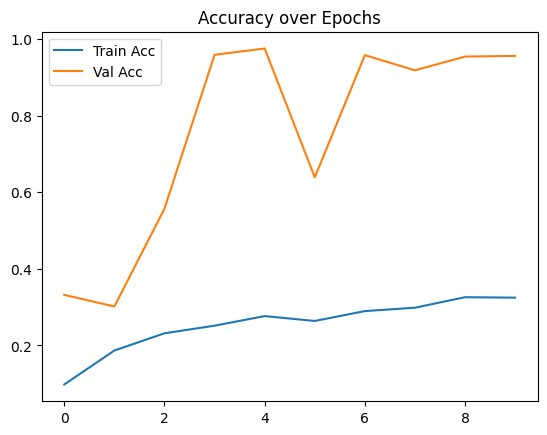

In [ ]:
# plot accuracy across epochs
plt.plot(history.history['accuracy'], label = 'Train Acc')
plt.plot(history.history['val_accuracy'], label = 'Val Acc')
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()

In [ ]:
# # Save the fully-trained model
# import pickle
# with open('trained_cnn_model.pkl', 'wb') as file:
#     pickle.dump(cnn_model, file)

# Save with Keras
cnn_model.save("sophia_cnn_model.h5")

In [ ]:
cnn_model.save("sophia_cnn_model.keras")

# Results

In [ ]:
cnn_model = keras.models.load_model("sophia_cnn_model.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Read the pickled data generators
import pickle
with open('trained_cnn_model.pkl', 'rb') as file:
    cnn_model = pickle.load(file)

## Make Predictions from our Test Dataset

In [ ]:
# Define the class names
street_sign_classes = list(valid_generator.class_indices.keys())

In [ ]:
street_sign_classes

['10mph',
 '20mph',
 '30mph',
 '40mph',
 'crossroads',
 'cycle_route_ahead',
 'frail',
 'give_way',
 'give_way_to_oncoming',
 'keep_left',
 'keep_right',
 'mini_roundabout',
 'no_entry',
 'no_left_turn',
 'no_motor_vehicles',
 'no_right_turn',
 'no_through_road',
 'one_way_traffic',
 'road_humps',
 'road_narrows_on_both_sides',
 'road_narrows_on_left',
 'road_narrows_on_right',
 'road_works',
 'school_crossing',
 'traffic_has_priority',
 'traffic_signals',
 'turn_left',
 'turn_left_ahead',
 'turn_right',
 'two_way_traffic',
 'zebra_crossing']

In [ ]:
# To display our images
def show_image(generator, index):
    """
    INPUTS
      generator: the Image generator object where the test data resides
      index: the index of the image in the test set that we want to use
    """
    image_batch, label_batch = generator[index]  # Get the batch
    image = image_batch[0]  # First image in the batch
    label = label_batch[0]

    # Plot the image
    plt.imshow(image)
    plt.axis('off')
    true_label = street_sign_classes[np.argmax(label)]
    plt.title("True Label: " + true_label)
    plt.show()

# To make predictions on an image
def make_predictions(model, generator, index):
    image_batch, _ = generator[index]  # Get a batch
    image = image_batch[0:1]  # First image only, but keep batch dimension
    preds = model.predict(image)
    return preds[0] # single (indexed) image prediction

# THIS IS THE FUNCTION YOU USE TO SPIT AN IMAGE AND PREDICTION!!
def sign_classifier(model, generator, index):
    show_image(generator, index)
    preds = make_predictions(model, generator, index)
    predicted_label = street_sign_classes[np.argmax(preds)]
    print("This is a " + predicted_label + "street sign!")

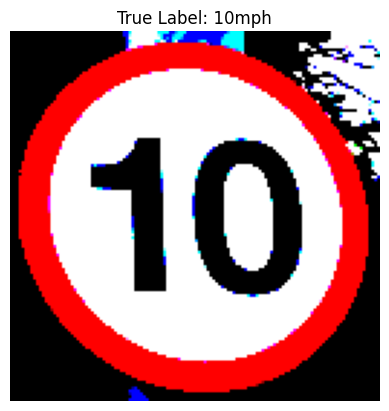

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
This is a 10mphstreet sign!


In [ ]:
sign_classifier(cnn_model, valid_generator, 4)

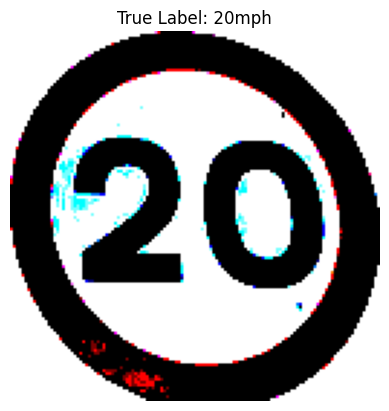

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
This is a 20mphstreet sign!


In [ ]:
sign_classifier(cnn_model, valid_generator, 32)

### Composite

In [ ]:
model_predict = cnn_model.predict(
    valid_generator
)
labels_predict = np.argmax(model_predict, axis = 1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


344/344 ━━━━━━━━━━━━━━━━━━━━ 3723s 11s/step


In [ ]:
# Save the fully-predicted labels
val_preds = {
    "model_predict": model_predict,
    "labels_predict": labels_predict
}

import pickle
with open('validation_preds_cnn_model.pkl', 'wb') as file:
    pickle.dump(val_preds, file)

<Figure size 1200x1200 with 0 Axes>

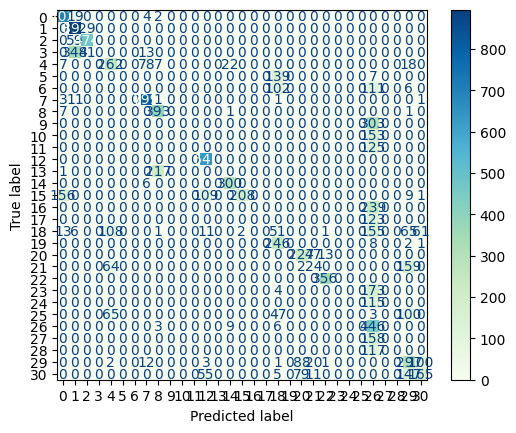

In [ ]:
plt.figure(figsize=(12, 12))
metrics.ConfusionMatrixDisplay.from_predictions(valid_generator.classes, labels_predict, cmap = "GnBu")

In [ ]:
accuracy = metrics.accuracy_score(valid_generator.classes, labels_predict)
print(f"CNN Model accuracy: {accuracy}")

CNN Model accuracy: 0.5667696220930233


## Complete Out-of-Sample Predictions

This data comes from a YouTube video that had shown UK street signs: https://youtu.be/83fn_DAItBA?feature=shared

(TODO: add these screenshots to the Shared Drive)

In [ ]:
# Test generators
# We don't augment our test data since it's not being learned in our model
datagen_test = ImageDataGenerator(
    samplewise_center = True
)

# Get data from the directory
data_dir = "./ood_test_set/"
set_seed = 22
batch_size = 32

# Validation data generator
test_generator = datagen_test.flow_from_directory(
    data_dir,
    target_size = (128, 128),
    batch_size = batch_size,
    class_mode = "categorical",
    seed = set_seed,
    shuffle = False # Keep order
)

Found 97 images belonging to 20 classes.


In [ ]:
# Make predictions
model_predict = cnn_model.predict(
    test_generator
)
labels_predict = np.argmax(model_predict, axis = 1)

In [ ]:
# Save the fully-predicted labels
test_preds = {
    "model_predict": model_predict,
    "labels_predict": labels_predict
}
with open('test_preds_cnn_model.pkl', 'wb') as file:
    pickle.dump(test_preds, file)

### Results of OOS Tests

In [ ]:
plt.figure(figsize=(12, 12))
metrics.ConfusionMatrixDisplay.from_predictions(test_generator.classes, labels_predict, cmap = "GnBu")

In [ ]:
accuracy = metrics.accuracy_score(test_generator.classes, labels_predict)
print(f"CNN Model accuracy: {accuracy}")

In [ ]:
test_generator.classes, labels_predict